# Example notebook for debugging your compression algorithm

This notebook shows how to import the functions from the `competition` folder, in case you want to debug using a notebook.
Remember that any code used in your entry needs to be in the `competition` folder, we will not run this notebook!

See the `README.md` for a description of how we will run your code.

In [1]:
import numpy as np
from typing import Tuple, NamedTuple, Optional
from cued_sf2_lab.laplacian_pyramid import quant1, quant2
from cued_sf2_lab.dct import dct_ii, colxfm, regroup
from cued_sf2_lab.bitword import bitword
from cued_sf2_lab.jpeg import diagscan, huffdflt, huffgen, huffenc, runampl, huffdes, HuffmanTable
from cued_sf2_lab.lbt import pot_ii



def DCT_freq_dep_quant1(Y, step_scalar):

    
    jpeg_table = np.array([[ 16,  11,  10 , 16,  24,  40 ,  51 ,  61]  , 
                  [  12 , 12,  14 , 19,  26 ,  58,   60,   55 ]  ,
                   [ 14,  13,  16,  24 , 40,   57,   69,   56  ] ,
                   [ 14 , 17 , 22,  29,  51 ,  87,   80 ,  62]   ,
                    [18 , 22 , 37,  56,  68 ,  109 , 103 , 77]   ,
                    [24 , 35 , 55,  64 , 81 ,  104  ,113 , 92]   ,
                    [49 , 64  ,78 , 87 , 103,  121  ,120 , 101]  ,
                    [72 , 92  ,95 , 98 , 112 , 100 , 103 ,99 ]])



    jpeg_table = np.array([[17,	18,	24,	47,	99,	99,	99,	99],
                   [ 18,	21,	26,	66,	99,	99,	99,	99],
                    [24,	26,	56,	99,	99,	99,	99,	99],
                    [47,	66,	99,	99,	99,	99,	99,	99],
                    [99,	99,	99,	99,	99,	99,	99,	99],
                    [99,	99,	99,	99,	99,	99,	99,	99],
                    [99	,99,	99,	99,	99,	99,	99,	99],
                    [99,	99,	99,	99,	99,	99,	99,	99]])


    jpeg_table = step_scalar*jpeg_table

    Yr = regroup(Y, 8)
    Yc = Yr.copy()
    it = Y.shape[0]//8
    for r in range(0, Y.shape[0], it):
        for c in range(0, Y.shape[1], it):
            Yc[r:r+it, c:c+it] = quant1(Yc[r:r+it, c:c+it], jpeg_table[r//it][c//it], jpeg_table[r//it][c//it])

    return regroup(Yc, 32)


def DCT_freq_dep_quant2(Z, step_scalar):
    jpeg_table = np.array([[ 16,  11,  10 , 16,  24,  40 ,  51 ,  61]  , 
                  [  12 , 12,  14 , 19,  26 ,  58,   60,   55 ]  ,
                   [ 14,  13,  16,  24 , 40,   57,   69,   56  ] ,
                   [ 14 , 17 , 22,  29,  51 ,  87,   80 ,  62]   ,
                    [18 , 22 , 37,  56,  68 ,  109 , 103 , 77]   ,
                    [24 , 35 , 55,  64 , 81 ,  104  ,113 , 92]   ,
                    [49 , 64  ,78 , 87 , 103,  121  ,120 , 101]  ,
                    [72 , 92  ,95 , 98 , 112 , 100 , 103 ,99 ]])

    
    jpeg_table = np.array([[17,	18,	24,	47,	99,	99,	99,	99],
                   [ 18,	21,	26,	66,	99,	99,	99,	99],
                    [24,	26,	56,	99,	99,	99,	99,	99],
                    [47,	66,	99,	99,	99,	99,	99,	99],
                    [99,	99,	99,	99,	99,	99,	99,	99],
                    [99,	99,	99,	99,	99,	99,	99,	99],
                    [99	,99,	99,	99,	99,	99,	99,	99],
                    [99,	99,	99,	99,	99,	99,	99,	99]])
    
    
    jpeg_table = step_scalar*jpeg_table

    Zr = regroup(Z, 8)
    Zc = Zr.copy()
    it = Z.shape[0]//8
    for r in range(0, Z.shape[0], it):
        for c in range(0, Z.shape[1], it):
            Zc[r:r+it, c:c+it] = quant2(Zc[r:r+it, c:c+it], jpeg_table[r//it][c//it], jpeg_table[r//it][c//it])

    return regroup(Zc, 32)





def jpegLBTFreqDepenc(X: np.ndarray,
              qstep: float,
              N: int = 8,
              M: int = 8,
              opthuff: bool = False,
              dcbits: int = 8,
              log: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    Encodes the image in X to generate a variable length bit stream.
    Parameters:
        X: the input greyscale image
        qstep: the quantisation step to use in encoding
        N: the width of the DCT block (defaults to 8)
        M: the width of each block to be coded (defaults to N). Must be an
            integer multiple of N - if it is larger, individual blocks are
            regrouped.
        opthuff: if true, the Huffman table is optimised based on the data in X
        dcbits: the number of bits to use to encode the DC coefficients
            of the DCT.
    Returns:
        vlc: variable length output codes, where ``vlc[:,0]`` are the codes and
            ``vlc[:,1]`` the number of corresponding valid bits, so that
            ``sum(vlc[:,1])`` gives the total number of bits in the image
        hufftab: optional outputs containing the Huffman encoding
            used in compression when `opthuff` is ``True``.
    '''

    if M % N != 0:
        raise ValueError('M must be an integer multiple of N!')

    # DCT on input image X.
    if log:
        print('Forward {} x {} DCT'.format(N, N))

    Pf, Pr = pot_ii(N, 2**0.5)
    t = np.s_[N // 2:-N // 2]
    Xp = X.copy()
    Xp[t, :] = colxfm(Xp[t, :], Pf)
    Xp[:, t] = colxfm(Xp[:, t].T, Pf).T

    C8 = dct_ii(N)
    Y = colxfm(colxfm(Xp, C8).T, C8).T

    # Quantise to integers.
    if log:
        print('Quantising to step size of {}'.format(qstep))
    Yq = DCT_freq_dep_quant1(Y, qstep).astype('int')

    # Generate zig-zag scan of AC coefs.
    scan = diagscan(M)

    # On the first pass use default huffman tables.
    if log:
        print('Generating huffcode and ehuf using default tables')
    dhufftab = huffdflt(1)  # Default tables.
    huffcode, ehuf = huffgen(dhufftab)

    # Generate run/ampl values and code them into vlc(:,1:2).
    # Also generate a histogram of code symbols.
    if log:
        print('Coding rows')
    sy = Yq.shape
    huffhist = np.zeros(16**2)
    vlc = []
    for r in range(0, sy[0], M):
        for c in range(0, sy[1], M):
            yq = Yq[r:r + M, c:c + M]
            # Possibly regroup
            if M > N:
                yq = regroup(yq, N)
            yqflat = yq.flatten('F')
            # Encode DC coefficient first
            dccoef = yqflat[0] + 2**(dcbits - 1)
            if dccoef not in range(2**dcbits):
                raise ValueError(
                    'DC coefficients too large for desired number of bits')
            vlc.append(np.array([[dccoef, dcbits]]))
            # Encode the other AC coefficients in scan order
            # huffenc() also updates huffhist.
            ra1 = runampl(yqflat[scan])
            vlc.append(huffenc(huffhist, ra1, ehuf))
    # (0, 2) array makes this work even if `vlc == []`
    vlc = np.concatenate([np.zeros((0, 2), dtype=np.intp)] + vlc)

    # Return here if the default tables are sufficient, otherwise repeat the
    # encoding process using the custom designed huffman tables.
    if not opthuff:
        if log:
            print('Bits for coded image = {}'.format(sum(vlc[:, 1])))
        return vlc, dhufftab

    # Design custom huffman tables.
    if log:
        print('Generating huffcode and ehuf using custom tables')
    dhufftab = huffdes(huffhist)
    huffcode, ehuf = huffgen(dhufftab)

    # Generate run/ampl values and code them into vlc(:,1:2).
    # Also generate a histogram of code symbols.
    if log:
        print('Coding rows (second pass)')
    huffhist = np.zeros(16**2)
    vlc = []
    for r in range(0, sy[0], M):
        for c in range(0, sy[1], M):
            yq = Yq[r:r + M, c:c + M]
            # Possibly regroup
            if M > N:
                yq = regroup(yq, N)
            yqflat = yq.flatten('F')
            # Encode DC coefficient first
            dccoef = yqflat[0] + 2**(dcbits - 1)
            vlc.append(np.array([[dccoef, dcbits]]))
            # Encode the other AC coefficients in scan order
            # huffenc() also updates huffhist.
            ra1 = runampl(yqflat[scan])
            vlc.append(huffenc(huffhist, ra1, ehuf))
    # (0, 2) array makes this work even if `vlc == []`
    vlc = np.concatenate([np.zeros((0, 2), dtype=np.intp)] + vlc)

    if log:
        print('Bits for coded image = {}'.format(sum(vlc[:, 1])))
        print('Bits for huffman table = {}'.format(
            (16 + max(dhufftab.huffval.shape)) * 8))

    return vlc, dhufftab


def jpegLBTFreqDepdec(vlc: np.ndarray,
              qstep: float,
              N: int = 8,
              M: int = 8,
              hufftab: Optional[HuffmanTable] = None,
              dcbits: int = 8,
              W: int = 256,
              H: int = 256,
              log: bool = False) -> np.ndarray:
    '''
    Decodes a (simplified) JPEG bit stream to an image
    Parameters:
        vlc: variable length output code from jpegenc
        qstep: quantisation step to use in decoding
        N: width of the DCT block (defaults to 8)
        M: width of each block to be coded (defaults to N). Must be an
            integer multiple of N - if it is larger, individual blocks are
            regrouped.
        hufftab: if supplied, these will be used in Huffman decoding
            of the data, otherwise default tables are used
        dcbits: the number of bits to use to decode the DC coefficients
            of the DCT
        W, H: the size of the image (defaults to 256 x 256)
    Returns:
        Z: the output greyscale image
    '''

    opthuff = (hufftab is not None)
    if M % N != 0:
        raise ValueError('M must be an integer multiple of N!')

    # Set up standard scan sequence
    scan = diagscan(M)

    if opthuff:
        if len(hufftab.bits.shape) != 1:
            raise ValueError('bits.shape must be (len(bits),)')
        if log:
            print('Generating huffcode and ehuf using custom tables')
    else:
        if log:
            print('Generating huffcode and ehuf using default tables')
        hufftab = huffdflt(1)
    # Define starting addresses of each new code length in huffcode.
    # 0-based indexing instead of 1
    huffstart = np.cumsum(np.block([0, hufftab.bits[:15]]))
    # Set up huffman coding arrays.
    huffcode, ehuf = huffgen(hufftab)

    # Define array of powers of 2 from 1 to 2^16.
    k = 2**np.arange(17)

    # For each block in the image:

    # Decode the dc coef (a fixed-length word)
    # Look for any 15/0 code words.
    # Choose alternate code words to be decoded (excluding 15/0 ones).
    # and mark these with vector t until the next 0/0 EOB code is found.
    # Decode all the t huffman codes, and the t+1 amplitude codes.

    eob = ehuf[0]
    run16 = ehuf[15 * 16]
    i = 0
    Zq = np.zeros((H, W))

    if log:
        print('Decoding rows')
    for r in range(0, H, M):
        for c in range(0, W, M):
            yq = np.zeros(M**2)

            # Decode DC coef - assume no of bits is correctly given in vlc table.
            cf = 0
            if vlc[i, 1] != dcbits:
                raise ValueError(
                    'The bits for the DC coefficient does not agree with vlc table'
                )
            yq[cf] = vlc[i, 0] - 2**(dcbits - 1)
            i += 1

            # Loop for each non-zero AC coef.
            while np.any(vlc[i] != eob):
                run = 0

                # Decode any runs of 16 zeros first.
                while np.all(vlc[i] == run16):
                    run += 16
                    i += 1

                # Decode run and size (in bits) of AC coef.
                start = huffstart[vlc[i, 1] - 1]
                res = hufftab.huffval[start + vlc[i, 0] - huffcode[start]]
                run += res // 16
                cf += run + 1
                si = res % 16
                i += 1

                # Decode amplitude of AC coef.
                if vlc[i, 1] != si:
                    raise ValueError(
                        'Problem with decoding .. you might be using the wrong hufftab table'
                    )
                ampl = vlc[i, 0]

                # Adjust ampl for negative coef (i.e. MSB = 0).
                thr = k[si - 1]
                yq[scan[cf - 1]] = ampl - (ampl < thr) * (2 * thr - 1)

                i += 1

            # End-of-block detected, save block.
            i += 1

            yq = yq.reshape((M, M)).T

            # Possibly regroup yq
            if M > N:
                yq = regroup(yq, M // N)
            Zq[r:r + M, c:c + M] = yq

    if log:
        print('Inverse quantising to step size of {}'.format(qstep))

    Zi = DCT_freq_dep_quant2(Zq, qstep)
    if log:
        print('Inverse {} x {} DCT\n'.format(N, N))
    C8 = dct_ii(N)
    Pf, Pr = pot_ii(N, 2**0.5)
    t = np.s_[N // 2:-N // 2]

    Z = colxfm(colxfm(Zi.T, C8.T).T, C8.T)
    Zp = Z.copy()
    Zp[:, t] = colxfm(Zp[:, t].T, Pr.T).T
    Zp[t, :] = colxfm(Zp[t, :], Pr.T)
    Z = colxfm(colxfm(Zi.T, C8.T).T, C8.T)
    
    return Zp

In [2]:
""" This file contains the `encode` function. Feel free to split it into smaller functions """
import numpy as np
from typing import Tuple, Any
# from common import HeaderType, jpeg_quant_size, jpeg2000_quant_size, n_level
from scipy.optimize import fsolve, minimize
from cued_sf2_lab.jpeg import HuffmanTable
from cued_sf2_lab.laplacian_pyramid import quant1, quant2, quantise, bpp
HeaderType = Tuple[HuffmanTable, float]
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
import matplotlib.pyplot as plt



n_level = 4
jpeg2000_quant_size = 18.03030303030303
def header_bits(header: HeaderType) -> int:
    """ Estimate the number of bits in your header.
    
    If you have no header, return `0`. """
    # replace this with your size estimate, and a comment explaining how you got it!

    huffcode, min_step = header
    return (len(huffcode.bits) + len(huffcode.huffval)) * 8 + 64 #float size for min step


def encode(X: np.ndarray) -> Tuple[np.ndarray, HeaderType]:
    """
    Parameters:
        X: the input grayscale image
    
    Outputs:
        vlc: the variable-length codes
        header: any additional parameters to be saved alongside the image
    """
    # replace this with your chosen encoding scheme. If you do not use a header,
    # then `return vlc, None`.
    X_normalised = X - 128.0
    min_step = fsolve(bit_diff, x0 = jpeg2000_quant_size, args = (X_normalised))[0]
    min_step = np.float64(min_step)
    vlc, hufftab = jpegLBTFreqDepenc(X_normalised, n_level, min_step, opthuff=True, dcbits=8)
    return vlc, (hufftab, min_step)

def bit_diff(qstep: float, img: np.ndarray) -> float:
    target_bits = 40960 - 1424  - 64  # using opthuff, need to subtract 1424 to transmit table

    vlc, hufftab = jpegLBTFreqDepenc(img, n_level, qstep, opthuff=True, dcbits= 9)
    total_bits = sum(vlc[:, 1])
    tbit_diff = np.abs(target_bits - total_bits)

    return tbit_diff

In [3]:
""" This file contains the `decode` function. Feel free to split it into smaller functions """
import numpy as np
from cued_sf2_lab.jpeg import jpegdec
from typing import Tuple, Any
# from common import my_function, HeaderType, jpeg_quant_size, jpeg2000_quant_size, n_level
from cued_sf2_lab.jpeg import HuffmanTable
HeaderType = Tuple[HuffmanTable, float]

n_level = 4
jpeg2000_quant_size = 18.03030303030303
def decode(vlc: np.ndarray, header: HeaderType) -> np.ndarray:
    """
    Parameters:
        X: the input grayscale image
    
    Outputs:
        vlc: the variable-length codes
        header: any additional parameters to be saved alongside the image
    """
    # replace this with your chosen decoding scheme

    hufftab, min_step = header
    Z =  jpegLBTFreqDepdec(vlc, 4, min_step, hufftab=hufftab, dcbits=8)
    Z += 128.0
    return Z

In [4]:
N = 8
def rms_diff(qstep, X):
    target_RMS = 4.94399555858676
    vlc, _ = jpegLBTFreqDepenc(X, qstep, N, N, log=False, dcbits= 16)
    Z = jpegLBTFreqDepdec(vlc, qstep, N, N, log=False, dcbits = 16)

    return np.abs(target_RMS - np.std(X - Z))

In [5]:
X, _ = load_mat_img('lighthouse.mat', img_info='X')
target_RMS = np.std(X - quantise(X, 17))
ref = bpp(quantise(X, 17))*X.size
optimal_step = fsolve(rms_diff, x0 = 15, args = (X))[0]

/var/folders/72/h4v6qzl52g77p5x7841mw5480000gn/T/ipykernel_74605/969730399.py:4: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  optimal_step = fsolve(rms_diff, x0 = 15, args = (X))[0]


RMS error for normal: 24.965211376441687
comresstion ratios for normal: 9.78461434908849


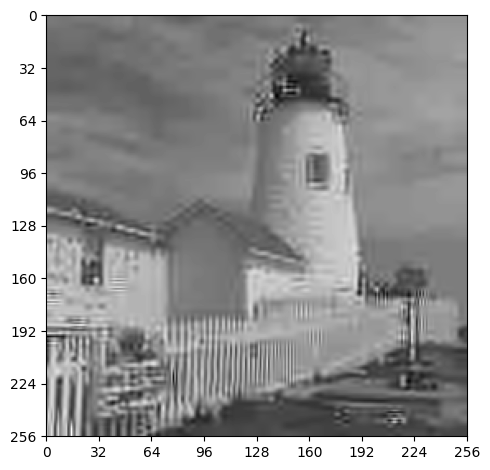

In [6]:
vlc_norm, _ = jpegLBTFreqDepenc(X, optimal_step, N, N, opthuff=False, log = False, dcbits=11)
Z_norm = jpegLBTFreqDepdec(vlc_norm, optimal_step, N, N, log=False, dcbits=11)

print("RMS error for normal: {}".format(np.std(X - Z_norm)))
print("comresstion ratios for normal: {}".format(ref/sum(vlc_norm[:,1])))


fig, ax = plt.subplots()
fig.tight_layout()
plot_image(Z_norm, ax=ax)

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.dct import colxfm, dct_ii, regroup
from cued_sf2_lab.dwt import dwt, idwt
from cued_sf2_lab.laplacian_pyramid import quant1, quant2, quantise, bpp
from cued_sf2_lab.jpeg import diagscan, runampl, huffdes, huffenc, huffgen, huffdflt, dwtgroup, HuffmanTable
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from scipy.optimize import fsolve, minimize
import numpy as np
import matplotlib.pyplot as plt
ref = bpp(quantise(X, 17))*X.size
n = 4
suffecient_step = 1
compression_ratio_mse = ref/(sum(vlc[:, 1]) + 1424)
print("suffecient mse step: {}".format(suffecient_step))
print(ref)
print("No. of bits for mse: {}".format(sum(vlc[:, 1]) + 1424))
print("RMS error for mse: {}".format(np.std(X - Z)))
print("Compression ratios for mse: {}".format(compression_ratio_mse))

NameError: name 'vlc' is not defined